<a href="https://colab.research.google.com/github/ehsan94/Deep-Learning/blob/master/Deutschland_COVID19_SHAP_0to75.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Total: 75-91

In [1]:
%pip install shap
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap

# Data

In [3]:
df = pd.read_stata('W:\COVID19\std_inz75_91.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [4]:
df.head()

,D_v404,D_v405,D_v406,D_v423,D_v424,D_v425,D_v442,D_Abhaen,D_Auslae,D_v483,...,G_Pendler_Potsdam,G_latitude,G_longitude,G_distance_Ischgl,Flag100_Pendler_Coesfeld,Flag100_Pendler_Rosenheim,Flag100_Pendler_Goettingen,std_inz_0to75,std_inz_75to91,eastwest
0,46.000000,12.4,-2.5,0.93,2.4,12.3,1.04,38.299999,9.1,3.2,...,0.0,50.549999,7.116667,457.259216,0.0,0.0,0.0,7.929436,51.103943,1.0
1,43.000000,16.0,-3.5,0.94,4.2,7.6,1.00,29.900000,8.0,2.9,...,0.0,48.466667,11.133333,173.721573,0.0,0.0,0.0,4.718663,97.875450,1.0
2,42.500000,14.9,-2.3,0.88,4.0,6.3,0.98,28.900000,12.6,4.0,...,0.0,48.400002,9.983334,156.045456,0.0,0.0,0.0,8.526311,125.029121,1.0
3,49.700001,-1.4,-7.5,0.88,-4.3,-13.3,1.04,50.799999,3.2,2.0,...,0.0,50.983334,12.433333,468.846863,0.0,0.0,0.0,1.614463,23.919840,0.0
4,44.700001,9.4,-1.5,0.93,-0.3,-7.4,1.02,34.099998,7.2,2.1,...,0.0,50.683334,7.650000,451.906799,0.0,0.0,0.0,5.352468,38.366455,1.0


In [5]:
Y = df['std_inz_75to91']
X = df.loc[:, ~df.columns.isin(['std_inz_75to91', 'eastwest'])]

# RF model

In [6]:
rf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5000, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)
rf.fit(X, Y)  

RandomForestRegressor(n_estimators=5000, random_state=0)

# SHAP values

In [7]:
#Kshap_values = shap.KernelExplainer(rf.predict, X).shap_values(X, nsamples=100)
shap_values = shap.TreeExplainer(rf).shap_values(X)

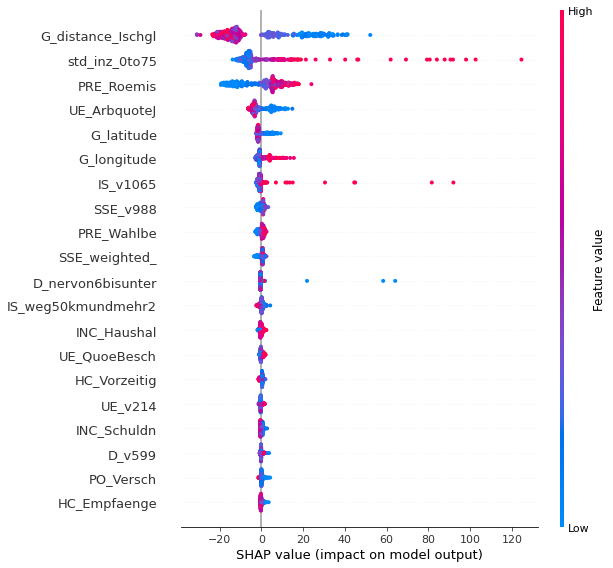

In [8]:
#shap.summary_plot(Kshap_values, X,max_display=10) #KernelExplainer
shap.summary_plot(shap_values, X,max_display=20)  #TreeExpliner

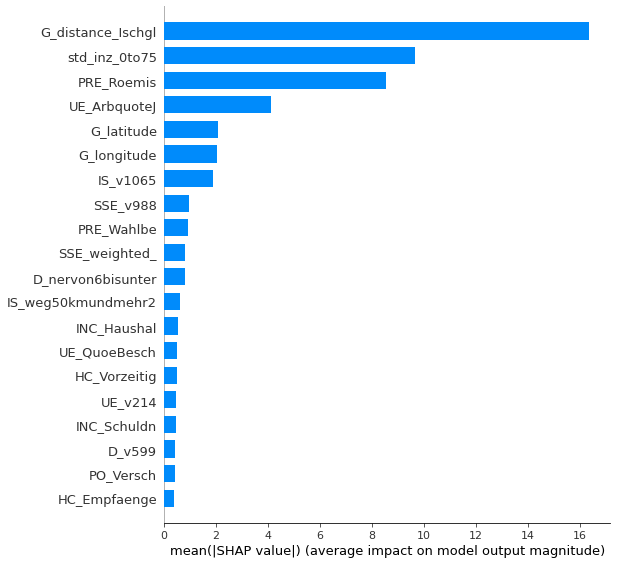

In [9]:
#shap.summary_plot(Kshap_values, X, plot_type="bar",max_display=10)
shap.summary_plot(shap_values, X, plot_type="bar",max_display=20)

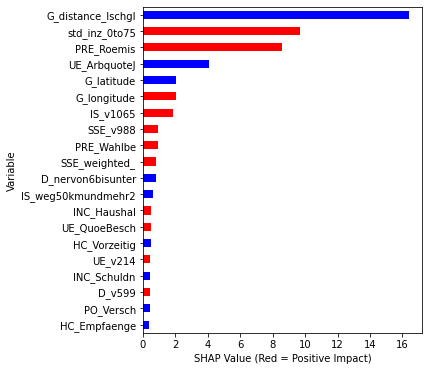

In [10]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    k2 = k2[-20:]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X) 